In [8]:
from import_images import getImages
import numpy as np
import torch
from cellpose import resnet_torch
from cellpose import transforms
import cv2
import time
from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torchmetrics.classification import BinaryJaccardIndex
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
print(torch.cuda.is_available())

True


In [53]:
def get_pre_activations(image,cpnet):

    print(cpnet.diam_mean, cpnet.diam_labels, cpnet.diam_mean/cpnet.diam_labels)
    x = transforms.resize_image(image, rsz=1,no_channels=True).astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x).unsqueeze(0)

    downsample = cpnet.downsample(x)
    style = cpnet.make_style(downsample[-1])
    print(downsample[0].shape)
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample).squeeze(0)[2]
    output = output.cpu().detach().numpy()
    output = cv2.resize(output, dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)

    return upsample, output

In [122]:
class ImageDataset(Dataset):
    def __init__(self, image, upsample, cellprob):
        self.image = image
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, upsample, cellprob
    
def get_crops(image,size):
    assert image.shape[0]%size == 0
    assert image.shape[0] == image.shape[1]
    crops = []
    for i in range(0,image.shape[0],size):
        for j in range(0,image.shape[1],size):
            crops.append(image[i:i+size,j:j+size])
    return crops

def reconstruct_image(crops, size):
    assert len(crops) > 0
    image_size = 1024
    size = 256
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    crop_idx = 0
    for i in range(0, image_size, size):
        for j in range(0, image_size, size):
            image[i:i+size, j:j+size] = crops[crop_idx]
            crop_idx += 1
    return image

def get_data(images, cpnet, crop_size=216):
    cp_upsamples = []
    cp_outputs = []
    for image in images:
        upsample, output = get_pre_activations(image,cpnet)
        cp_upsamples.append(upsample)
        cp_outputs.append(output)

    images_torch = torch.from_numpy(np.array(images, dtype=np.float32))
    train_images, test_images, train_upsamples, test_upsamples, train_cellprob, test_cellprob = train_test_split(images_torch, cp_upsamples, cp_outputs, test_size=0.1, random_state=42)
    
    #print(train_images[0].shape, train_upsamples[0].shape, train_cellprob[0].shape)

    images_normalised = []
    for image in train_images:
        min_val = torch.min(image)
        max_val = torch.max(image)
        normalized_image = (image - min_val) / (max_val - min_val)
        images_normalised.append(normalized_image)

    images_torch_rotated = []
    for image in images_normalised:
        images_torch_rotated.append(image)
        for i in range(3):
            image = torch.rot90(image, 1, [0, 1])
            images_torch_rotated.append(image)

    images_torch_rotated_flipped = []
    for image in images_torch_rotated:
        images_torch_rotated_flipped.append(image)
        images_torch_rotated_flipped.append(torch.flip(image, [1]))

    cp_upsamples_normalised = []
    for upsample in train_upsamples:
        min_val = np.min(upsample)
        max_val = np.max(upsample)
        normalized_upsample = (upsample - min_val) / (max_val - min_val)
        cp_upsamples_normalised.append(normalized_upsample)

    cp_upsamples_rotated = []
    for upsample in cp_upsamples_normalised:
        cp_upsamples_rotated.append(upsample)
        for i in range(3):
            upsample = np.rot90(upsample, 1, [1, 2])
            cp_upsamples_rotated.append(upsample)

    cp_upsamples_rotated_flipped = []
    for upsample in cp_upsamples_rotated:
        cp_upsamples_rotated_flipped.append(upsample)
        cp_upsamples_rotated_flipped.append(np.flip(upsample, [2]))

    cp_outputs_rotated = []
    for output in train_cellprob:
        cp_outputs_rotated.append(output)
        for i in range(3):
            output = np.rot90(output, 1, [0, 1])
            cp_outputs_rotated.append(output)

    cp_outputs_rotated_flipped = []
    for output in cp_outputs_rotated:
        cp_outputs_rotated_flipped.append(output)
        cp_outputs_rotated_flipped.append(np.flip(output, [1]))

    images_cropped = []
    for image in images_torch_rotated_flipped:
        #print(image.shape)
        crops = get_crops(image,crop_size)
        for crop in crops:
            images_cropped.append(crop)

    cp_upsampled_cropped = []
    for (i,upsample) in enumerate(cp_upsamples_rotated_flipped):
        crops_per_chan = []
        for chan in upsample:
            chan = cv2.resize(chan, dsize=(1080, 1080), interpolation=cv2.INTER_CUBIC)
            crops = get_crops(chan,crop_size)
            crops_per_chan.append(crops)

        for j in range(25):
            crop_channels_of_crop = []
            for k in range(32):
                crop_channels_of_crop.append(crops_per_chan[k][j])
            crop_channels_of_crop = np.array(crop_channels_of_crop)
            crop_channels_of_crop = crop_channels_of_crop.copy()
            crop_channels_of_crop = torch.from_numpy(crop_channels_of_crop)
            cp_upsampled_cropped.append(crop_channels_of_crop)

    cp_outputs_cropped = []
    for output in cp_outputs_rotated_flipped:
        output = cv2.resize(output, dsize=(1080, 1080), interpolation=cv2.INTER_CUBIC)
        crops = get_crops(output,crop_size)
        for crop in crops:
            crop = torch.from_numpy(crop.copy())
            cp_outputs_cropped.append(crop)

    return images_cropped, cp_upsampled_cropped, cp_outputs_cropped, test_images, test_upsamples, test_cellprob

In [12]:
class KD_loss(torch.nn.Module):
    def __init__(self, alpha, beta):
        super(KD_loss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_32_pred, y_32_true, y_3_pred, y_3_true):
        
        #32-channel loss
        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())

        #3-channel loss
        y_3_bce_loss = F.mse_loss(y_3_pred, y_3_true.float())

        return y_32_loss * self.alpha, y_3_bce_loss * self.beta

In [13]:
def trainEpoch(unet, train_loader, test_loader, validation_loader, loss_fn, optimiser, scheduler, epoch_num, device):
    time_start = time.time()
    
    unet.train()

    train_y_32_loss, train_map_loss = 0, 0

    for image, upsample, cp_output in train_loader:

        if device == 'mps':
            image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, map_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)
    
        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        train_y_32_loss += loss_32.item()
        train_map_loss += loss_map.item()

         # zero out the accumulated gradients

        #I want to get two losses, one for the 32-channel output and one for the 3-channel output
        #I then want to freeze certain channels before putting the losses backwards
        unet.encoder.requires_grad = True #repetitive but just to be clear
        unet.decoder.requires_grad = True
        unet.head.requires_grad = False
        loss_32.backward(retain_graph=True)

        
        unet.encoder.requires_grad = False
        unet.decoder.requires_grad = False
        unet.head.requires_grad = True
        loss_map.backward(retain_graph=True)

        optimiser.step() # update model parameters
        optimiser.zero_grad()

    if scheduler is not None:
        scheduler.step()

    train_y_32_loss, train_map_loss = train_y_32_loss/len(train_loader), train_map_loss/len(train_loader)


    val_y_32_loss, val_map_loss, val_IoU = 0, 0, 0
    for image, upsample, cp_output in validation_loader:
        if device == 'mps':
            image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, map_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)
    
        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        val_y_32_loss += loss_32.item()
        val_map_loss += loss_map.item()

        #IoU score
        jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
        map_pred = F.sigmoid(map_pred)
        cp_output = F.sigmoid(cp_output)
        cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
        iou = jaccard(map_pred, cp_output)
        if not torch.isnan(iou):
            val_IoU += iou
        else:
            val_IoU += 0
        

    val_y_32_loss, val_map_loss, val_IoU = val_y_32_loss/len(validation_loader), val_map_loss/len(validation_loader), val_IoU.item()/len(validation_loader)
    
    #we might add displaying later on
    
    if epoch_num is None:
        print('Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)
    else:
        print('Epoch: ', epoch_num, 'Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)

    return unet

In [14]:
import ezomero
from omero_data import connect, extract_channel, progressbar

conn = connect(user='rz200',password='omeroreset')

plate = 1237
image_ids = ezomero.get_image_ids(conn,plate=plate)

print('In plate',plate,'we have',len(image_ids),'images')

data_images = []
for i in progressbar(range(len(image_ids)), "Computing: ", 40):
    data_images.append(ezomero.get_image(conn, image_ids[i])[1])

data_images_one = extract_channel(data_images, 0)
data_images_two = extract_channel(data_images, 1)


Connection successful
In plate 1237 we have 36 images
Computing: [########################################] 36/36



In [41]:
#images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
#images_directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/uploads"
#file_names, images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(data_images_one, dtype=np.float32)).unsqueeze(0)

#directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
#directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/datasets/Fluo-C2DL-Huh7/01/models/CP_20230601_101328"
directory = "/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/U2OS_Tub_Hoechst"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

In [42]:
for image in images_torch:
    upsample, output = get_pre_activations(image,cpnet)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [128]:
images_cropped, cp_upsampled_cropped, cp_outputs_cropped, test_images, test_upsamples, test_cellprob = get_data(data_images_one[:7], cpnet)

Parameter containing:
tensor([30.]) Parameter containing:
tensor([33.4113]) tensor([0.8979])
torch.Size([1, 32, 1080, 1080])
Parameter containing:
tensor([30.]) Parameter containing:
tensor([33.4113]) tensor([0.8979])
torch.Size([1, 32, 1080, 1080])
Parameter containing:
tensor([30.]) Parameter containing:
tensor([33.4113]) tensor([0.8979])
torch.Size([1, 32, 1080, 1080])
Parameter containing:
tensor([30.]) Parameter containing:
tensor([33.4113]) tensor([0.8979])
torch.Size([1, 32, 1080, 1080])
Parameter containing:
tensor([30.]) Parameter containing:
tensor([33.4113]) tensor([0.8979])
torch.Size([1, 32, 1080, 1080])
Parameter containing:
tensor([30.]) Parameter containing:
tensor([33.4113]) tensor([0.8979])
torch.Size([1, 32, 1080, 1080])
Parameter containing:
tensor([30.]) Parameter containing:
tensor([33.4113]) tensor([0.8979])
torch.Size([1, 32, 1080, 1080])
len(images_torch_rotated_flipped) 48
len(cp_upsamples_rotated_flipped) 48
chan shape (1080, 1080)
25
chan shape (1080, 1080)


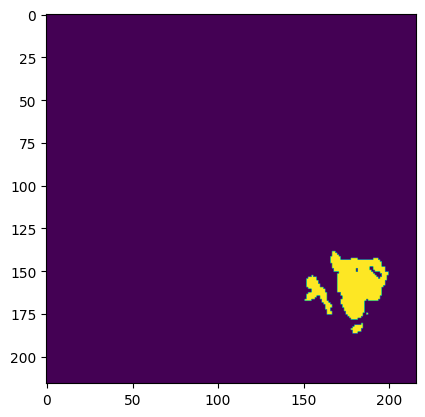

In [156]:
plt.imshow(cp_outputs_cropped[6]>0.5)

In [130]:
train_images, val_images, train_upsamples, val_upsamples, train_cellprob, val_cellprob = train_test_split(images_cropped, cp_upsampled_cropped, cp_outputs_cropped, test_size=0.1, random_state=42)

num_train_images = 10
train_dataset = ImageDataset(images_cropped, cp_upsampled_cropped, cp_outputs_cropped)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

validation_dataset = ImageDataset(val_images, val_upsamples, val_cellprob)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

test_dataset = ImageDataset(test_images, test_upsamples, test_cellprob)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [126]:
unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('cuda:0')

In [131]:
loss_fn = KD_loss(alpha=1, beta=1)
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.1)

#I think a decaying scheduler is best, not a cyclic one
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.000001, max_lr=0.1)

for epoch in range(500):
    #print(scheduler.get_last_lr())
    unet = trainEpoch(unet, train_loader, test_loader, validation_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, device='cuda:0')

Epoch:  0 Train 32 loss:  0.04565119267130891 Train map loss 2.035713537322978 Val 32 loss:  0.04621932075048486 Val map loss:  2.199602102736632 Val IoU:  tensor(0.6994, device='cuda:0') Time:  117.49268937110901
Epoch:  1 Train 32 loss:  0.039721181867644194 Train map loss 1.934123430668066 Val 32 loss:  0.03519692178815603 Val map loss:  2.1295233527819315 Val IoU:  tensor(0.7006, device='cuda:0') Time:  122.45103645324707
Epoch:  2 Train 32 loss:  0.02866472442013522 Train map loss 1.8931469515152275 Val 32 loss:  0.023179906699806452 Val map loss:  2.0405153481289746 Val IoU:  tensor(0.7033, device='cuda:0') Time:  121.88377928733826
Epoch:  3 Train 32 loss:  0.01962077427500238 Train map loss 1.8829227755963802 Val 32 loss:  0.016533402384569247 Val map loss:  2.0047771578654645 Val IoU:  tensor(0.7066, device='cuda:0') Time:  121.71208953857422
Epoch:  4 Train 32 loss:  0.015240917178646972 Train map loss 1.886980177157869 Val 32 loss:  0.01461508647383501 Val map loss:  2.15248

KeyboardInterrupt: 

In [ ]:
torch.save(unet.state_dict(), 'unet_U2OS_test_1')

In [ ]:
#now need to add post-processing and prediction functions and show some tests data
#then will need to add the random seed weight test

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
!nvidia-smi

Thu Jun 22 19:23:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.39       Driver Version: 472.39       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000   WDDM  | 00000000:01:00.0  On |                  Off |
| 44%   54C    P2    39W / 140W |   2599MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [147]:
val_IoU = 0
for image, upsample, cp_output in validation_loader:
    print('x')
    (image, upsample, cp_output) = (image.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0')) # sending the data to the device (cpu or GPU)

    image = image.unsqueeze(1)
    y_16_pred, y_32_pred, map_pred = unet(image)
    y_32_pred = y_32_pred.squeeze(1)
    map_pred = map_pred.squeeze(1)

    device = 'cuda:0'
    #IoU score
    jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
    map_pred = F.sigmoid(map_pred)
    cp_output = F.sigmoid(cp_output)
    cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
    iou = jaccard(map_pred, cp_output)
    if not torch.isnan(iou):
        val_IoU += iou
    else:
        val_IoU += 0

x


c:\Users\rz200\Anaconda3\envs\omero-env\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x


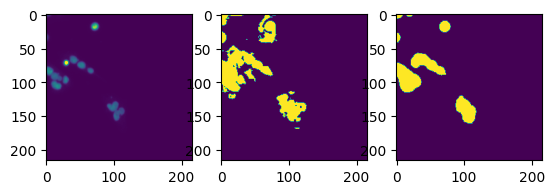

[0.00422513 0.0050336  0.00667166 ... 0.99999976 0.9999999  1.        ]


In [148]:
plt.subplot(1,3,1)
plt.imshow(image.squeeze(0).cpu().detach().numpy()[0])

cp_output = cp_output.squeeze(0)
cp_output = cp_output.cpu().detach().numpy()
plt.subplot(1,3,2)
plt.imshow(cp_output)

map_pred = map_pred.squeeze(0)
map_pred = map_pred.cpu().detach().numpy()
plt.subplot(1,3,3)
plt.imshow(map_pred>0.5)
plt.show()

print(np.unique(map_pred))

In [141]:
print(val_IoU/len(validation_loader))

tensor(0.7086, device='cuda:0')
